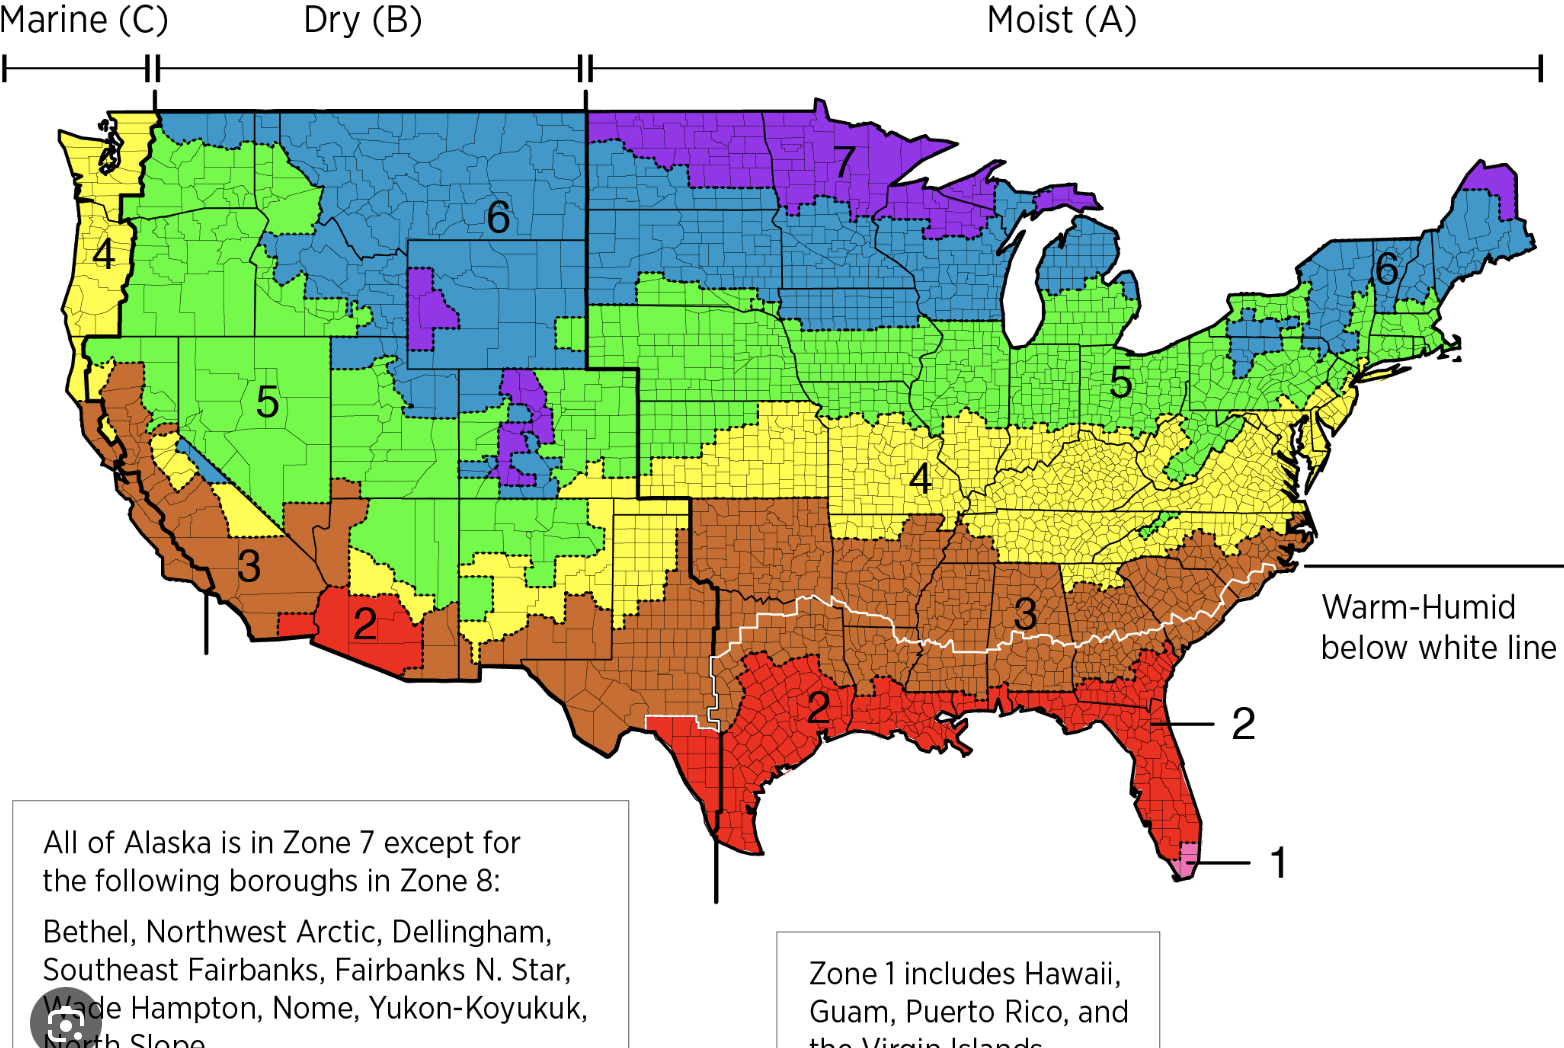

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

dataset_path = Path().resolve() / "datasets"
# get the full path
print(f"Dataset path: {dataset_path}")

data_path = dataset_path / "comstock"
# get the full path
print(f"Data path: {data_path}")

# auto reload any changes in the module
%load_ext autoreload

# ComStock

### Pull down ComStock data

To do this, you should be able to just simply run the `comstock_processor.py` file within VSCode. The data will be saved into 
the ComStock subfolder. It takes a while to run (10ish minutes).

In [ ]:
# %run comstock_processor.py

### Read in ComStock data

In [ ]:
# read in the comstock exported file, yes we could just read the parquet, maybe update?
df_all = pd.read_csv(data_path / "All-All-All-0-selected_metadata.csv")

In [ ]:
# get the dimensions
print(df_all.shape)
# show all states
print(df_all["in.state"].unique())
# show all the building types
print(df_all["in.comstock_building_type"].unique())

In [ ]:
# save the names of the fields to a list
fields = df_all.columns
open(data_path / "fields.txt", "w").write("\n".join(fields))

# force the climate zone to be a string
df_all["in.ashrae_iecc_climate_zone_2006"] = df_all["in.ashrae_iecc_climate_zone_2006"].astype(str)
# print the unique values
print(df_all["in.ashrae_iecc_climate_zone_2006"].unique())

In [ ]:
# find if climate zone 7A or 7B or 7
df_cz7 = df_all[df_all["in.ashrae_iecc_climate_zone_2006"].str.contains("7")]
print(df_cz7["in.state"].unique())
df_co_cz7 = df_cz7[df_cz7["in.state"] == "CO"]
df_pitkin = df_all[df_all["in.county_name"] == "CO, Pitkin County"]

# print the dimensions for each dataframe
print(f"all: {df_all.shape}")
print(f"cz7: {df_cz7.shape}")
print(f"cz7 co: {df_co_cz7.shape}")
print(f"cz7 pitkin: {df_pitkin.shape}")

In [ ]:
display(df_cz7)
display(df_pitkin)

# # list all the columns that have "weighted" and "intensity" in the name
# weighted_cols = [col for col in df_all.columns if 'weighted' in col]
# print(weighted_cols)

In [ ]:
# use seaborn

# return the quartiles of the column out.site_energy.total.energy_consumption_intensity
print(df_cz7["out.site_energy.total.energy_consumption_intensity"].describe())

# create kernel density plot of the column out.site_energy.total.energy_consumption_intensity, using seaborn
sns.kdeplot(df_cz7["out.site_energy.total.energy_consumption_intensity"], shade=True)
# add dashed lines for the quartiles
describe_data = df_cz7["out.site_energy.total.energy_consumption_intensity"].describe()
plt.axvline(describe_data["25%"], color="r", linestyle="--")
plt.axvline(describe_data["50%"], color="g", linestyle="--")
plt.axvline(describe_data["75%"], color="b", linestyle="--")
plt.xlabel("Site Energy EUI (kBtu/ft2)")
plt.title(f"All Building Types - n={len(df_cz7)}")
# display the quartiles in a text box
plt.text(0.5, 0.5, describe_data, transform=plt.gca().transAxes)
plt.xlim(0)

# add in the df_piitkin data
sns.kdeplot(df_pitkin["out.site_energy.total.energy_consumption_intensity"], shade=True)
plt.show()

In [ ]:
# create KDE's for only "SmallOffice", "MediumOffice", "LargeOffice"
df_cz7_office = df_cz7[df_cz7["in.comstock_building_type"].isin(["SmallOffice", "MediumOffice", "LargeOffice"])]
df_cz7_co_office = df_co_cz7[df_co_cz7["in.comstock_building_type"].isin(["SmallOffice", "MediumOffice", "LargeOffice"])]

# create kernel density plot of the column out.site_energy.total.energy_consumption_intensity, using seaborn
sns.kdeplot(df_cz7_office["out.site_energy.total.energy_consumption_intensity"], fill=True, legend=True)
# add in the df_piitkin data
sns.kdeplot(df_cz7["out.site_energy.total.energy_consumption_intensity"], fill=True, legend=True)
sns.kdeplot(df_cz7_co_office["out.site_energy.total.energy_consumption_intensity"], fill=True, legend=True)
# add dashed lines for the quartiles
describe_data = df_cz7_office["out.site_energy.total.energy_consumption_intensity"].quantile([0, 0.25, 0.5, 0.75, 1.0])
describe_data = describe_data.to_dict()
display(describe_data)
# show only describe from the column out.site_energy.total.energy_consumption_intensity

# add line at 47.2 called CBECS C/VC CZ Office
plt.axvline(47.2, color="k", linestyle="--", label="CBECS C/VC CZ Office")
plt.axvline(60, color="k", linestyle=":", label="ASHRAE Std 100")

plt.axvline(describe_data[0.25], color="r", linestyle="--")
plt.axvline(describe_data[0.5], color="g", linestyle="--")
plt.axvline(describe_data[0.75], color="b", linestyle="--")
plt.xlabel("Site Energy EUI - Offices (kBtu/ft2)")
plt.title("Distribution of Office Building Types EUI")


# display the quartiles in a text box
textstr = "ComStock All CZ7 Offices Stats:\n" + "\n".join([f"{k*100}%: {v:.2f}" for k, v in describe_data.items()])

plt.text(0.5, 0.1, textstr, transform=plt.gca().transAxes)
plt.xlim(0, 200)

# add legend
plt.legend(["CZ7 Offices (All)", "CZ7 Buildings (All)", "CZ7 Offices (in CO)", "CBECS C/VC CZ Office 25%-ile", "Std100 EUI Target 25%-ile"])

plt.show()

# CBECS



In [ ]:
# read in the xlsx spreadsheet sheet called cbecs2018_final_public

cbecs2018 = pd.read_excel(dataset_path / "cbecs" / "cbecs2018_final_public.xlsx", sheet_name="cbecs2018_final_public")

In [ ]:
display(cbecs2018)

In [ ]:
# calculate the total kbtu/ft2 for each building
cbecs2018["total_kbtu_ft2"] = cbecs2018["MFBTU"] / cbecs2018["SQFT"]


# create the kde plot of all kbtu/ft2
sns.kdeplot(cbecs2018["total_kbtu_ft2"], fill=True)

# filter only offices
offices = cbecs2018[cbecs2018["PBA"] == 2]
sns.kdeplot(offices["total_kbtu_ft2"], fill=True)

# only offices in very cold
offices_very_cold = offices[offices["PUBCLIM"] == 1]
sns.kdeplot(offices_very_cold["total_kbtu_ft2"], fill=True)
# add legend
plt.legend(["All", "Offices", "Offices in Very Cold"])
plt.xlim(0, 200)
plt.title("CBECS Offices")


# 1st quartile of the offices_very_cold
offices_very_cold_1st_quartile = offices_very_cold["total_kbtu_ft2"].quantile(0.25)
# plot as line
plt.axvline(offices_very_cold_1st_quartile, color="black", linestyle=":")

# ESPM Colorado Site EUI
https://portfoliomanager.energystar.gov/dataExplorer/?_gl=1*1cjut0r*_ga*NzE4OTQ5MDM4LjE3MjM1ODY2NzY.*_ga_S0KJTVVLQ6*MTcyMzU4NjY3Ni4xLjAuMTcyMzU4NjY3Ni4wLjAuMA..

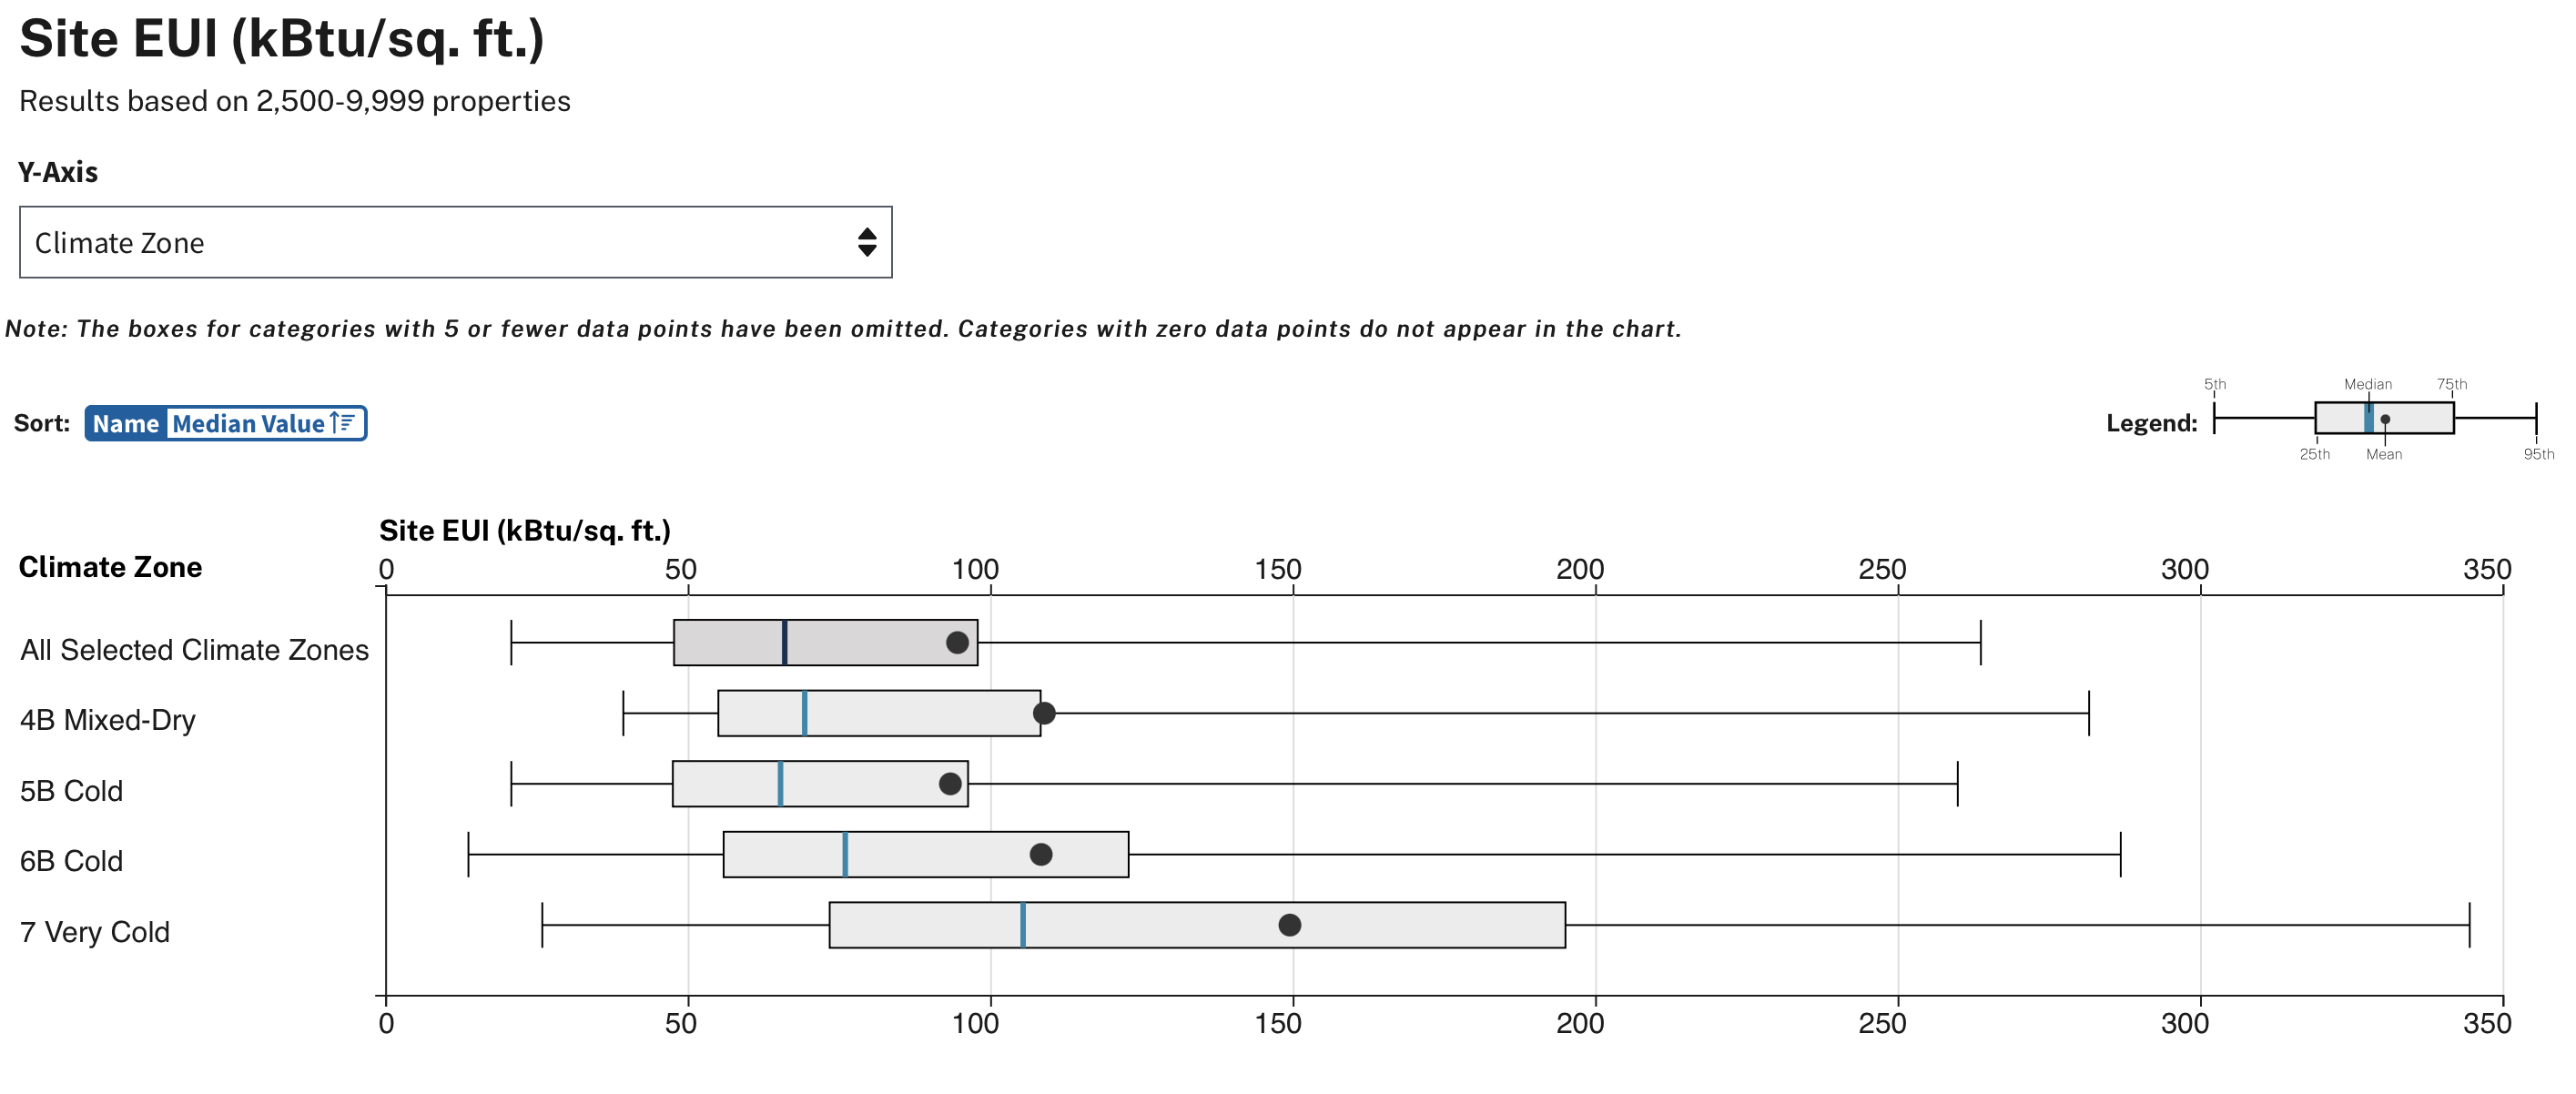{ width=50% }


In [ ]:
# show histogram of the building types - in.comstock_building_type

# It would be nice to have this image for each of the data sources
sns.histplot(df_cz7["in.comstock_building_type"])
plt.xlabel("Building Type")
plt.title("Building Types in All Climate Zone 7")
plt.xticks(rotation=90)
plt.show()

# show histogram of the building types - in.comstock_building_type
sns.histplot(df_co_cz7["in.comstock_building_type"])
plt.xlabel("Building Type")
plt.title("Building Types in CO Climate Zone 7")
plt.xticks(rotation=90)
plt.show()

# Data Comparison

In [ ]:
# Read in std data
std100_25thPercentile = pd.read_excel(
    dataset_path / "std100" / "std100data_percentiles_allclimatezones_allbuildingtypes.xlsx", sheet_name="25thPercentile"
)
std100_40thPercentile = pd.read_excel(
    dataset_path / "std100" / "std100data_percentiles_allclimatezones_allbuildingtypes.xlsx", sheet_name="40thPercentile"
)
std100_50thPercentile = pd.read_excel(
    dataset_path / "std100" / "std100data_percentiles_allclimatezones_allbuildingtypes.xlsx", sheet_name="50thPercentile"
)

# display(std25thPercentile)

# Read in ESPM data
espm_data = pd.read_excel(dataset_path / "espm" / "ESPM_allBuildingTypes_AllClimateZones.xlsx", sheet_name="Report")

# display(espm_data)

# Comparison boxplot of all Zone 7 building types

In [ ]:
# CBECS Data Handling:
#   calculate the total kbtu/ft2 for each building
#   add in literal column for data_source for union and display in visualization
#   Filter just to climate zone "Cold or Very Cold" (See lookups.py in the cbecs data folder for additional definitions for different numbers, not the same as climate zone numbers)
#   Select data needed for union and visualization
#   Note if needed: PBA is building type
cbecs2018["EUI _kBTUft2"] = cbecs2018["MFBTU"] / cbecs2018["SQFT"]
cbecs2018["data_source"] = "CBECS"
cbecs2018["PUBCLIM"] = 1
cbecs2018ForComparison = cbecs2018[["data_source", "EUI _kBTUft2"]]

# Comstock Data Handling:
#   Filter just to climate zone 7 (very cold)
#   add in literal column for data_source for union and display in visualization
#   Select data needed for union and visualization
#   Rename columns for union
#   Note if needed: in.comstock_building_type is building type for comstock data;
comstock_cz7 = df_all[df_all["in.ashrae_iecc_climate_zone_2006"].str.contains("7")]
comstock_cz7["data_source"] = "COMSTOCK"
comstockForComparison = comstock_cz7[["data_source", "out.site_energy.total.energy_consumption_intensity"]]
comstockForComparison = comstockForComparison.rename(columns={"out.site_energy.total.energy_consumption_intensity": "EUI _kBTUft2"})

# ESPM Data Handling
#   add in literal column for data_source for union and display in visualization
#   Filter just to climate zone 7 (very cold)
#   Select data needed for union and visualization
#   Rename columns for union
espm_data["data_source"] = "ESPM"
espm_data_cz7 = espm_data[espm_data["ClimateZone"].str.contains("7")]
espm_dataForComparison = espm_data_cz7[["data_source", "Median"]]
espm_dataForComparison = espm_dataForComparison.rename(columns={"Median": "EUI _kBTUft2"})

# Union data_sources for visualization
union_df = pd.concat([cbecs2018ForComparison, comstockForComparison, espm_dataForComparison], ignore_index=True)

# Create box plot
sns.boxplot(data=union_df, x="EUI _kBTUft2", y="data_source")

# Create percentile lines, averaged for all building types in zone 7
std100_25thPercentile_mean = std100_25thPercentile[7].mean()
std100_40thPercentile_mean = std100_40thPercentile[7].mean()
std100_50thPercentile_mean = std100_50thPercentile[7].mean()


plt.axvline(std100_25thPercentile_mean, color="r", linestyle="--")
plt.axvline(std100_40thPercentile_mean, color="g", linestyle="--")
plt.axvline(std100_50thPercentile_mean, color="b", linestyle="--")
plt.xlabel("Site Energy EUI (kBtu/ft2)")
plt.ylabel("Data Source")
plt.title("Comparison of Climate Zone 7 Standards for All Building Types")
plt.xlim(0, 250)

# Comparison boxplot of Zone 7 Limited to Office and Retail Building Types

In [ ]:
# CBECS Data Handling:
#   Filter to retail and office building types
#       Note: Only included "2 - Office" and "25 - Retail other than mall"; did not include "23 - Strip shopping center" or "24 - Enclosed mall"
#   calculate the total kbtu/ft2 for each building
#   add in literal column for data_source for union
#   Filter just to climate zone "Cold or Very Cold" (See lookups.py in the cbecs data folder for additional definitions for different numbers, not the same as climate zone numbers)
#   Select data needed for union and visualization
cbecs2018_OfficeAndRetail = cbecs2018[cbecs2018["PBA"].isin([2, 25])]
cbecs2018_OfficeAndRetail["EUI _kBTUft2"] = cbecs2018_OfficeAndRetail["MFBTU"] / cbecs2018_OfficeAndRetail["SQFT"]
cbecs2018_OfficeAndRetail["data_source"] = "CBECS"
cbecs2018_OfficeAndRetail["PUBCLIM"] = 1
cbecs2018_OfficeAndRetailForComparison = cbecs2018_OfficeAndRetail[["data_source", "EUI _kBTUft2"]]

# Comstock Data Handling:
#   Filter to retail and office building types
#       Note: did not include RetailStripMall
#   Filter just to climate zone 7 (very cold)
#   add in literal column for data_source for union and display in visualization
#   Select data needed for union and visualization
#   Rename columns for union
comstock_OfficeAndRetail = df_all[
    df_all["in.comstock_building_type"].isin(["LargeOffice", "SmallOffice", "RetailStandalone", "MediumOffice"])
]
comstock_OfficeAndRetail_cz7 = comstock_OfficeAndRetail[comstock_OfficeAndRetail["in.ashrae_iecc_climate_zone_2006"].str.contains("7")]
comstock_OfficeAndRetail_cz7["data_source"] = "COMSTOCK"
comstock_OfficeAndRetail_cz7ForComparison = comstock_OfficeAndRetail_cz7[
    ["data_source", "out.site_energy.total.energy_consumption_intensity"]
]
comstock_OfficeAndRetail_cz7ForComparison = comstock_OfficeAndRetail_cz7ForComparison.rename(
    columns={"out.site_energy.total.energy_consumption_intensity": "EUI _kBTUft2"}
)

# ESPM Data Handling
#   Filter to retail and office building types
#       Note: did not include "Mailing Center/Post Office", "Medical Office", or "Veterinary Office"
#   add in literal column for data_source for union and display in visualization
#   Filter just to climate zone 7 (very cold)
#   Select data needed for union and visualization
#   Rename columns for union
espm_data_OfficeAndRetail = espm_data[
    espm_data["PropertyTypeSubcategory"].isin(["Other - Retail/Mall", "Retail Store", "Financial Office", "Office"])
]
espm_data_OfficeAndRetail["data_source"] = "ESPM"
espm_data_OfficeAndRetail = espm_data_OfficeAndRetail[espm_data_OfficeAndRetail["ClimateZone"].str.contains("7")]
espm_data_OfficeAndRetail = espm_data_OfficeAndRetail[["data_source", "Median"]]
espm_data_OfficeAndRetailForComparison = espm_data_OfficeAndRetail.rename(columns={"Median": "EUI _kBTUft2"})

# Union data_sources for visualization
union_df = pd.concat(
    [cbecs2018_OfficeAndRetailForComparison, comstock_OfficeAndRetail_cz7ForComparison, espm_data_OfficeAndRetailForComparison],
    ignore_index=True,
)

# Create box plot
sns.boxplot(data=union_df, x="EUI _kBTUft2", y="data_source")

# Create percentile lines, averaged for all building types in zone 7
# Filter to retail and office building types
#   Note: Did not include "Medical office (nondiagnostic)", "Medical office (diagnostic)","Post office/postal center", "Courthouse/probation office","Enclosed mall", or "Strip shopping mall"
std100_25thPercentile_OfficeAndRetail = std100_25thPercentile[
    std100_25thPercentile["Commercial Building Type"].isin(
        ["Other retail", "Retail store", "Admin/professional office", "Government office", "Mixed-use office", "Other office"]
    )
]
std100_25thPercentile_mean_OfficeAndRetail = std100_25thPercentile_OfficeAndRetail[7].mean()

std100_40thPercentile_OfficeAndRetail = std100_40thPercentile[
    std100_40thPercentile["Commercial Building Type"].isin(
        ["Other retail", "Retail store", "Admin/professional office", "Government office", "Mixed-use office", "Other office"]
    )
]
std100_40thPercentile_mean_OfficeAndRetail = std100_40thPercentile_OfficeAndRetail[7].mean()

std100_50thPercentile_OfficeAndRetail = std100_50thPercentile[
    std100_50thPercentile["Commercial Building Type"].isin(
        ["Other retail", "Retail store", "Admin/professional office", "Government office", "Mixed-use office", "Other office"]
    )
]
std100_50thPercentile_mean_OfficeAndRetail = std100_50thPercentile_OfficeAndRetail[7].mean()


plt.axvline(std100_25thPercentile_mean_OfficeAndRetail, color="r", linestyle="--")
plt.axvline(std100_40thPercentile_mean_OfficeAndRetail, color="g", linestyle="--")
plt.axvline(std100_50thPercentile_mean_OfficeAndRetail, color="b", linestyle="--")
plt.xlabel("Site Energy EUI (kBtu/ft2)")
plt.ylabel("Data Source")
plt.title("Comparison of Climate Zone 7 Standards for Retail and Office Building Types")
plt.xlim(0, 250)